In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# Definizione funzioni

In [2]:
def RMSE_Loss(actual, predicted):
    """Root Mean Squared Error"""
    return torch.sqrt(torch.mean(torch.square(actual - predicted)))

In [3]:
def getRemoteDataset():
    return pd.read_csv('https://raw.githubusercontent.com/Uniba-dev-projects/forecasting-framework/synthetic_dataset_analysis/synthetic_dataset/synthetic_dataset.csv')    

In [4]:
def extractDataframeAndSeries(key, dataset):
    df = dataset[[key]]
    df = df.rename(columns={key: "t"}).reset_index()
    df.series = df.t.str.replace(",",".", regex=True).astype(float)
    return df, df.series.squeeze().dropna()

In [5]:
def calculateLoss(y, y_predicted):
    loss = []
    for i in range(len(y)):
        loss.append(abs(y[i]-y_predicted[i]))
    return loss

In [6]:
def showPerformanceGraph(label, portion, y_train, y_test, y_predicted_train, y_predicted_test, loss_train, loss_test, rmse_train, rmse_test):
    total = len(y_train) + len(y_test)
    plt.figure(figsize=(30,5))
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(0, total, 1), np.concatenate((y_train, y_test), axis=0))
    plt.plot(np.arange(0, total, 1), np.concatenate((y_predicted_train, y_predicted_test), axis=0))
    plt.legend(["Series", "Predicted", "Train and test set splitter"])

    plt.subplot(1, 3, 2)
    plt.plot(np.arange(0, total, 1), np.concatenate((loss_train, loss_test), axis=0))
    plt.legend(["Loss", "Train and test set splitter"])

    plt.subplot(1, 3, 3)
    plt.plot(rmse_train)
    plt.plot(rmse_test)
    plt.title("Last RMSE Train = "+str(rmse_train[-1])+"\n Last RMSE Test = "+str(rmse_test[-1]))
    plt.legend(["RMSE Train", "RMSE Test"])
    
    plt.suptitle(label)

# Inizializzazione e Visualizzazione Serie Temporali Sintentiche

In [7]:
dataset = getRemoteDataset()
_, series1 = extractDataframeAndSeries('y1(t) = t/1000 = y1(t-1)+0.001', dataset)
_, series2 = extractDataframeAndSeries('y2(t)=y2(t-1)*0.999', dataset)
_, series3 = extractDataframeAndSeries('y3(t)=y1(t)+y2(t)', dataset)
_, series4 = extractDataframeAndSeries('y4(t) = y4(t-1)-0.001', dataset)
_, series5 = extractDataframeAndSeries('y5(t)=y1(t)*t%2+y4(t)*(1-t%2)', dataset)
_, series6 = extractDataframeAndSeries('y6(t)=sin(t)', dataset)

# DatasetManager e Inizializzazione Long Short Term Memory
DatasetManager restituisce da una serie temporale un pandas.DataFrame definendo il nuemro di feature e il numero di variabili target.

In [8]:
class DatasetManager():
    def __getPandasFromNumpySeries(self, series, features_sequences=1, target_sequences=1, offset=0):

        dfTemp = pd.DataFrame({"ref": series})
        dfTemp.ref = dfTemp.ref.astype(float)
        for i in range(target_sequences):
            dfTemp['t+'+str(target_sequences-i)] = dfTemp.ref.shift(i)

        dfTemp['t'] = dfTemp.ref.shift(target_sequences)

        for j in range(features_sequences-1):
            dfTemp['t-'+str(j+1)] = dfTemp.ref.shift(target_sequences+j+1)

        dfTemp.drop(columns=["ref"], inplace=True)
        dropLine = features_sequences+target_sequences-1

        if(offset > 0):
            dfTemp['t'] = dfTemp['t'].shift(offset)
            for i in range(features_sequences-1):
                dfTemp['t-'+str(i+1)] = dfTemp['t-'+str(i+1)].shift(offset)
        
        dfTemp.drop(np.arange(0, dropLine+offset), inplace=True)
    
        return dfTemp[dfTemp.columns[::-1]].reset_index().drop(columns=["index"])
    
    def __getScaledDataFrame(self, df):
        tempColumns = df.columns
        scaler = MinMaxScaler()
        scalerDf = scaler.fit(df.to_numpy())
        df_scaled = scalerDf.transform(df)
        return pd.DataFrame(df_scaled, columns=tempColumns)

    def __init__(self, sequences, features_sequences=1, target_sequences=1, offset=0, portion=0.8):
        self.sequences = sequences
        self.features_sequences = features_sequences
        self.target_sequences = target_sequences
        self.offset = offset
        self.portion = portion
        tempDf = self.__getPandasFromNumpySeries(sequences, features_sequences, target_sequences, offset)
        self.df = self.__getScaledDataFrame(tempDf)

    def __len__(self):
        return len(self.sequences)

    def __get_x_y(self):
      return self.df[self.df.columns[0:self.features_sequences]].to_numpy(), self.df[self.df.columns[self.features_sequences:]].to_numpy()


    def __train_and_test_set__(self):
      x, y = self.__get_x_y()
      X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8)
      return torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

    def __get_entire_series__(self):
      x, y = self.__get_x_y()
      return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
 


In [9]:
class CNN_Linear_Predictor(nn.Module):
    def __init__(self, n_inp, l_1 = 180, conv1_out = 6, conv1_kernel = 36, conv2_kernel = 12, n_out = 1):
        super(CNN_Linear_Predictor, self).__init__()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv1 = nn.Conv1d(
            in_channels = 1,
            out_channels = conv1_out,
            kernel_size = conv1_kernel,
            padding = conv1_kernel - 1
        )
        self.conv2 = nn.Conv1d(
            in_channels = conv1_out,
            out_channels = conv1_out * 2,
            kernel_size = conv2_kernel,
            padding = conv2_kernel - 1
        )
        feature_tensor = self.fe_stack(torch.Tensor([[0]*n_inp]))
        self.lin1 = nn.Linear(feature_tensor.size()[1], l_1)
        self.lin2 = nn.Linear(l_1, n_out)
        
    def fe_stack(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.flatten(start_dim = 1)
        return x

    def dm_stack(self, x):
        x1 = F.relu(self.lin1(x))
        y = self.lin2(x1)
        return y

    def forward(self, x):
        x = self.fe_stack(x)
        y = self.dm_stack(x)
        return y

In [10]:
def executeCNN_Lin(label, series, feature_sequences=1, target_sequences=1, portion=0.8, offset=0, num_epochs=25):
    dataset = DatasetManager(
        series,
        features_sequences=feature_sequences,
        target_sequences=target_sequences,
        portion=portion,
        offset=offset
    )
    X_train, X_test, y_train, y_test = dataset.__train_and_test_set__()

    cnnLin = CNN_Linear_Predictor(feature_sequences)
    optimizer = optim.Adam(cnnLin.parameters(), lr=0.001)

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    for t in range(num_epochs):
        y_train_pred = cnnLin(X_train)
        loss = RMSE_Loss(y_train, y_train_pred)

        cnnLin.eval()
        with torch.no_grad():
            y_test_pred = cnnLin(X_test)
            test_loss = RMSE_Loss(y_test, y_test_pred)
            test_hist[t] = test_loss.item()

        if(t%10 == 0):
          print(f'Epoch {t} train loss:{loss.item()} test loss: {test_loss.item()}')
        
        train_hist[t] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    showPerformanceGraph(
        label = label,
        portion=portion,
        y_train=y_train.squeeze(),
        y_test=y_test.squeeze(),
        y_predicted_train=y_train_pred.detach().numpy().flatten(),
        y_predicted_test=y_test_pred.detach().numpy().flatten(),
        loss_train=calculateLoss(y_train.squeeze(), y_train_pred.detach().numpy().flatten()),
        loss_test=calculateLoss(y_test.squeeze(), y_test_pred.detach().numpy().flatten()),
        rmse_train=train_hist,
        rmse_test=test_hist
    )

    x_series, y_series = dataset.__get_entire_series__()
    cnnLin.eval()
    with torch.no_grad():
        yhat_series = cnnLin(x_series)
        plt.figure(figsize=(25,5))
        plt.plot(y_series.detach().numpy())
        plt.plot(yhat_series.detach().numpy())
        plt.legend(["True", "Predicted"])


# Execute CNN-SemiLinear

In [18]:
features_length = 5 #Default 1 (Sostituire i valori per gli esperimenti)
offset = 3 #Default 0 (Sostituire i valori per gli esperimenti)
portion_train_test = 0.8 #Default 0.8 (Sostituire i valori per gli esperimenti)
num_epochs = 100

Epoch 0 train loss:0.5108178853988647 test loss: 0.5127540826797485
Epoch 10 train loss:0.225282683968544 test loss: 0.2234184443950653
Epoch 20 train loss:0.16370713710784912 test loss: 0.16154327988624573
Epoch 30 train loss:0.07223543524742126 test loss: 0.07084732502698898
Epoch 40 train loss:0.03409843146800995 test loss: 0.036286041140556335
Epoch 50 train loss:0.015111308544874191 test loss: 0.015480570495128632
Epoch 60 train loss:0.006186856422573328 test loss: 0.006094877142459154
Epoch 70 train loss:0.00413917051628232 test loss: 0.0038826263044029474
Epoch 80 train loss:0.002333990531042218 test loss: 0.0021382872946560383
Epoch 90 train loss:0.011383836157619953 test loss: 0.011448916979134083


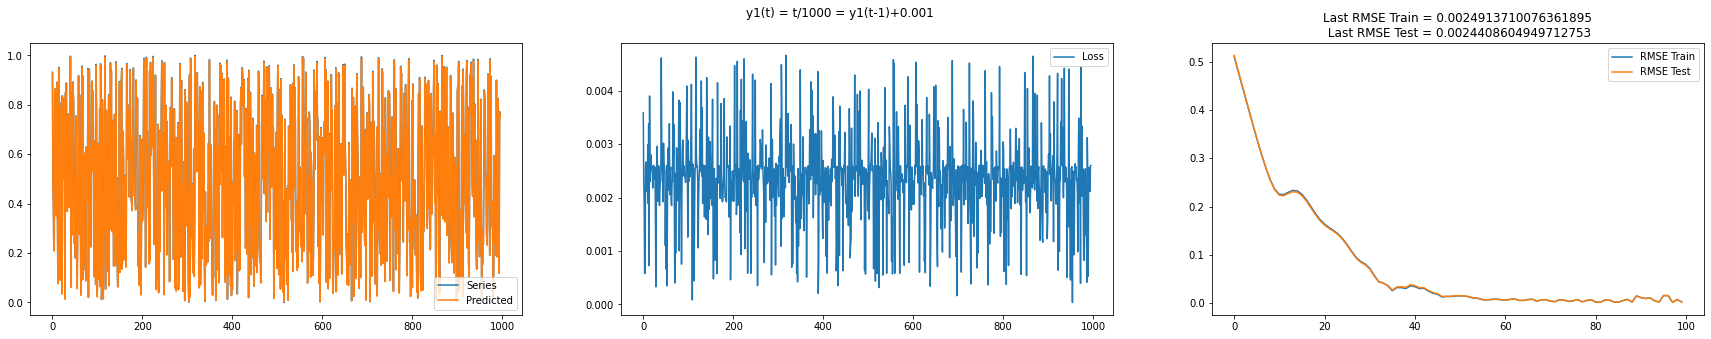

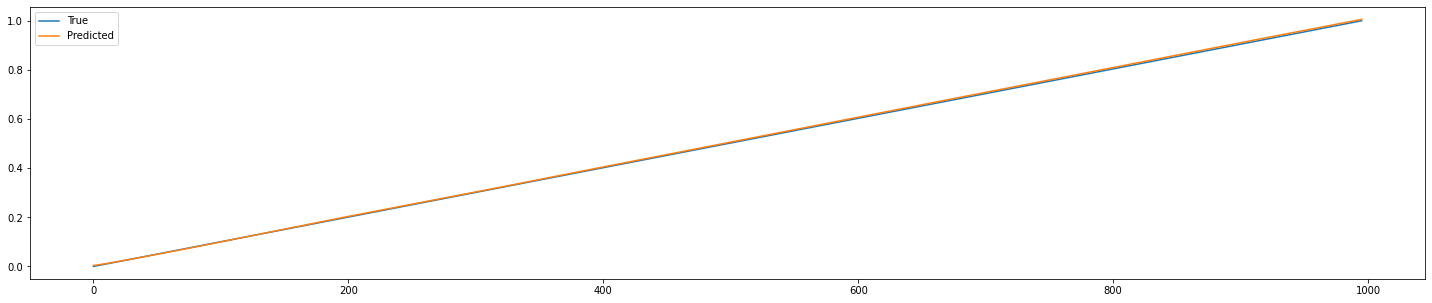

In [ ]:
executeCNN_Lin("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:0.5081778764724731 test loss: 0.4854463040828705
Epoch 10 train loss:0.24900291860103607 test loss: 0.2429979145526886
Epoch 20 train loss:0.21023544669151306 test loss: 0.2076873779296875
Epoch 30 train loss:0.14410357177257538 test loss: 0.14397813379764557
Epoch 40 train loss:0.0300008412450552 test loss: 0.030744656920433044
Epoch 50 train loss:0.02226584404706955 test loss: 0.021436579525470734
Epoch 60 train loss:0.010402281768620014 test loss: 0.010468448512256145
Epoch 70 train loss:0.006615945603698492 test loss: 0.006259712390601635
Epoch 80 train loss:0.010072839446365833 test loss: 0.009920219890773296
Epoch 90 train loss:0.03285441920161247 test loss: 0.03200862184166908


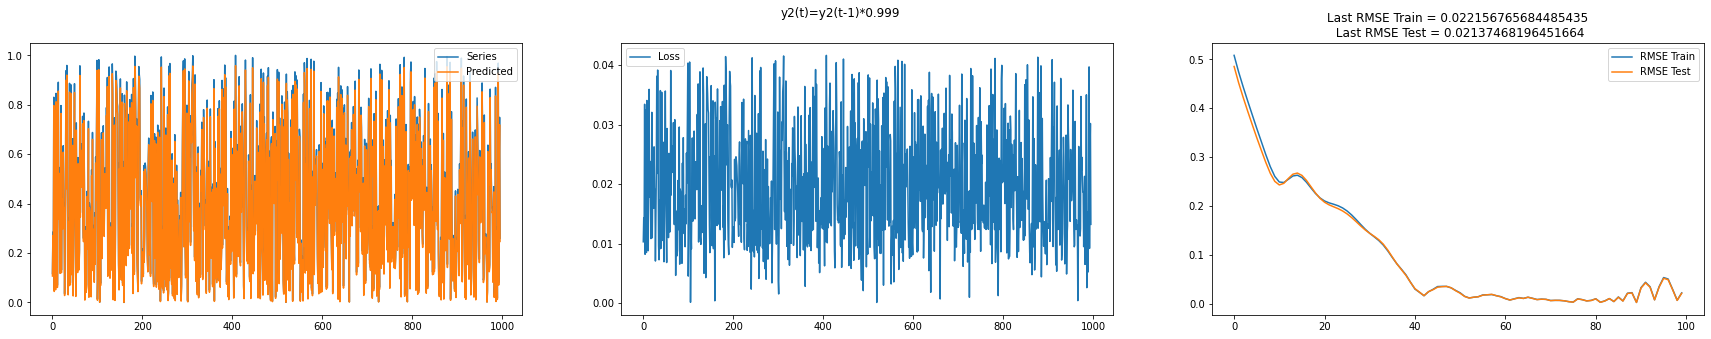

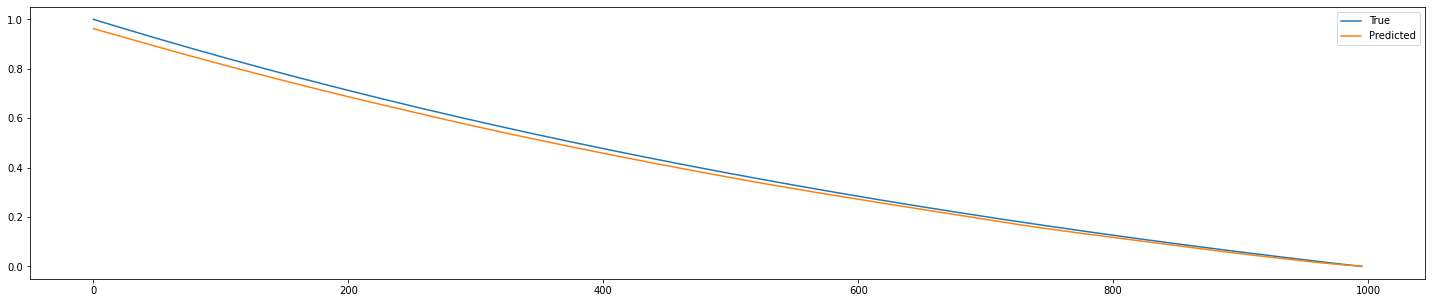

In [ ]:
executeCNN_Lin("y2(t)=y2(t-1)*0.999", series2, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:0.3980790078639984 test loss: 0.42260468006134033
Epoch 10 train loss:0.2429541051387787 test loss: 0.23510998487472534
Epoch 20 train loss:0.09895986318588257 test loss: 0.09805560857057571
Epoch 30 train loss:0.04236830770969391 test loss: 0.04217515513300896
Epoch 40 train loss:0.011052881367504597 test loss: 0.010622311383485794
Epoch 50 train loss:0.01571134477853775 test loss: 0.015195140615105629
Epoch 60 train loss:0.015006763860583305 test loss: 0.015596641227602959
Epoch 70 train loss:0.01412077248096466 test loss: 0.014271405525505543
Epoch 80 train loss:0.01564832031726837 test loss: 0.016064675524830818
Epoch 90 train loss:0.005046776961535215 test loss: 0.005343254655599594


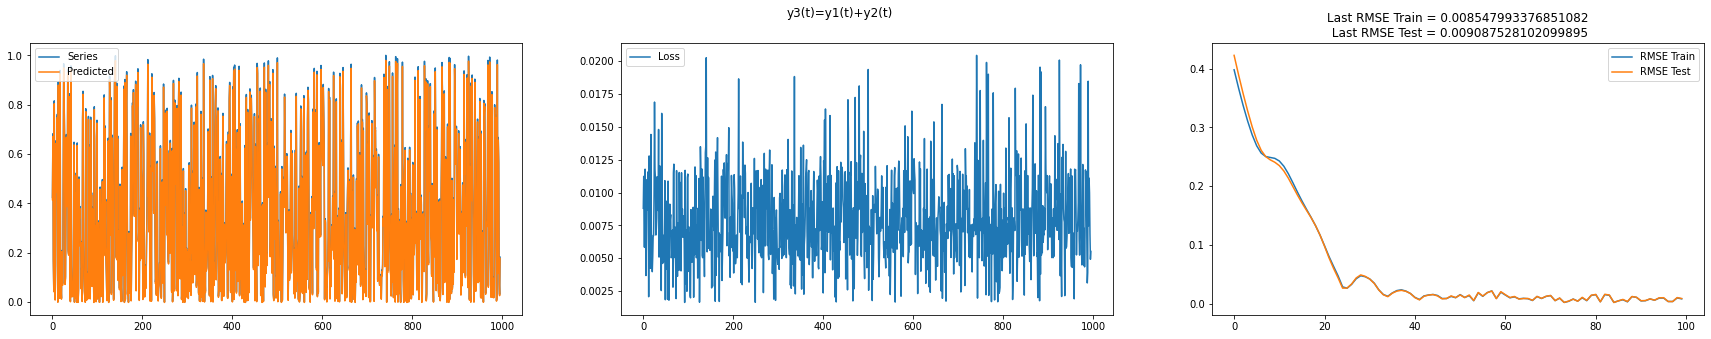

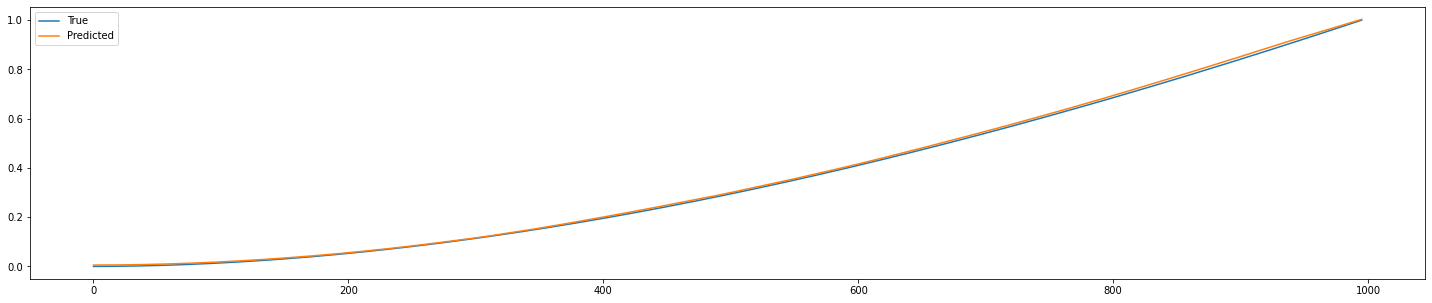

In [ ]:
executeCNN_Lin("y3(t)=y1(t)+y2(t)", series3, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:0.5793935656547546 test loss: 0.6096379160881042
Epoch 10 train loss:0.3484322130680084 test loss: 0.371883362531662
Epoch 20 train loss:0.20027655363082886 test loss: 0.1984158754348755
Epoch 30 train loss:0.1210886612534523 test loss: 0.12730008363723755
Epoch 40 train loss:0.06373484432697296 test loss: 0.06741946190595627
Epoch 50 train loss:0.048583950847387314 test loss: 0.05150680989027023
Epoch 60 train loss:0.0301486998796463 test loss: 0.03344562277197838
Epoch 70 train loss:0.021622315049171448 test loss: 0.024996506050229073
Epoch 80 train loss:0.01461429987102747 test loss: 0.01686733216047287
Epoch 90 train loss:0.009569557383656502 test loss: 0.011480522342026234


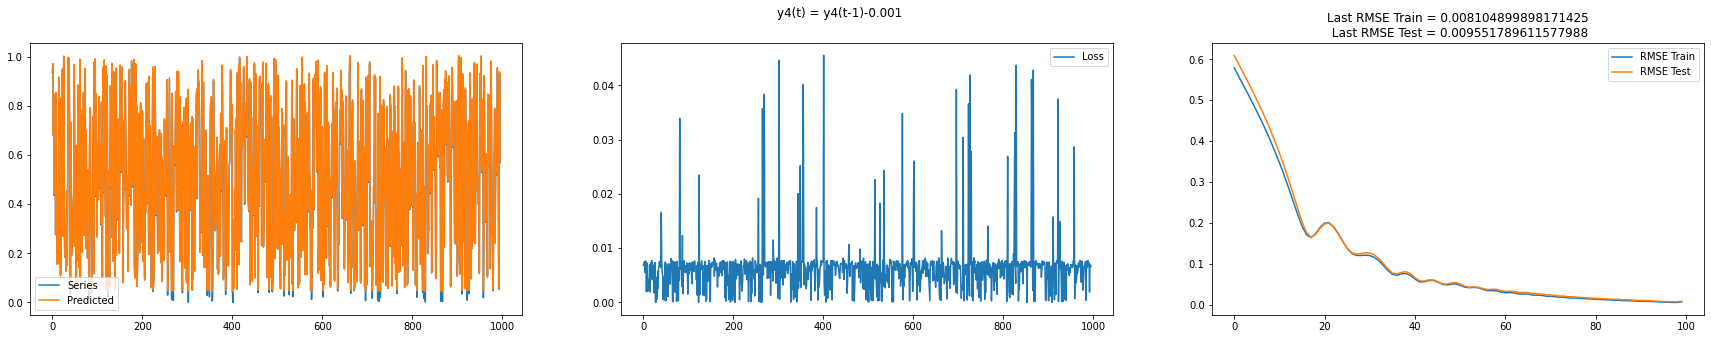

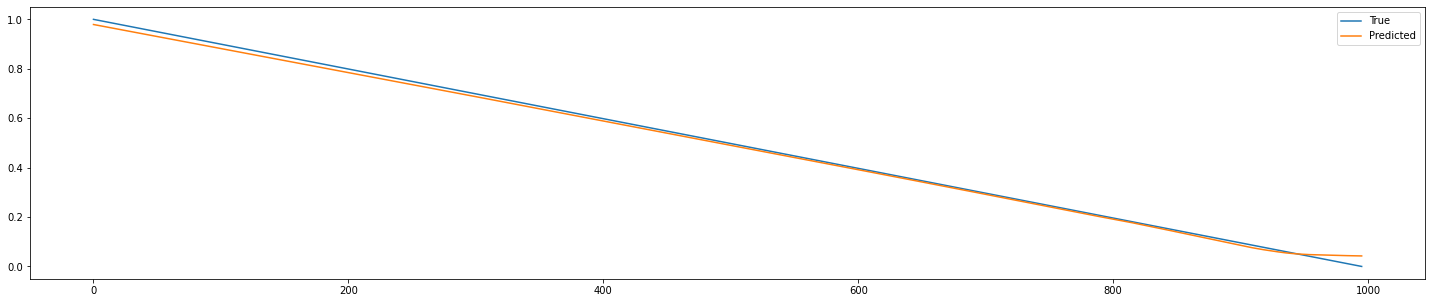

In [ ]:
executeCNN_Lin("y4(t) = y4(t-1)-0.001", series4, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:0.5238445401191711 test loss: 0.5740905404090881
Epoch 10 train loss:0.2964218854904175 test loss: 0.3070223331451416
Epoch 20 train loss:0.2759725749492645 test loss: 0.2792659103870392
Epoch 30 train loss:0.2461373507976532 test loss: 0.26074180006980896
Epoch 40 train loss:0.18399204313755035 test loss: 0.18705494701862335
Epoch 50 train loss:0.07045627385377884 test loss: 0.07039971649646759
Epoch 60 train loss:0.041470643132925034 test loss: 0.04115568846464157
Epoch 70 train loss:0.014683814719319344 test loss: 0.01411967258900404
Epoch 80 train loss:0.00818751659244299 test loss: 0.008092408068478107
Epoch 90 train loss:0.005135000217705965 test loss: 0.0054665436036884785


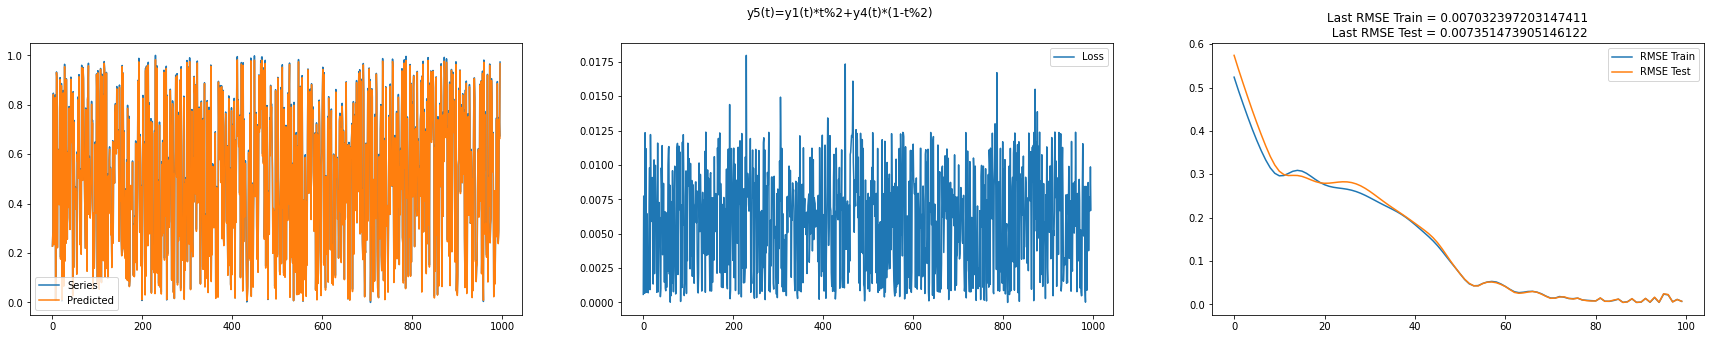

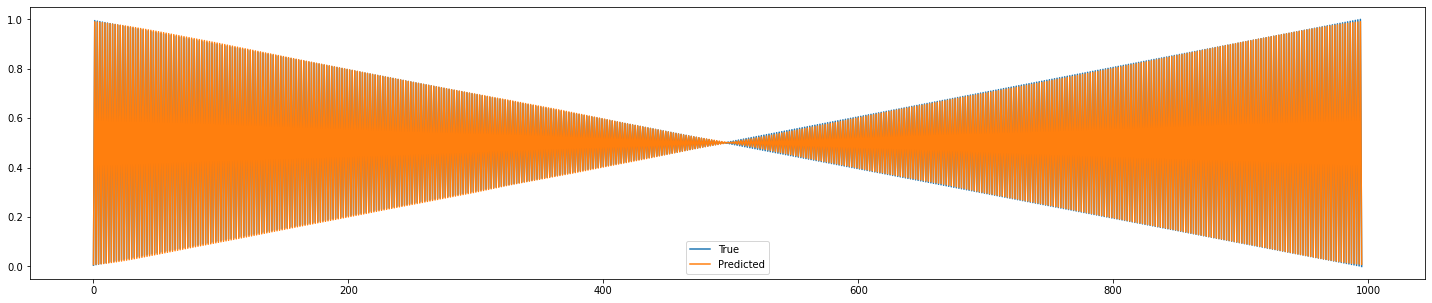

In [ ]:
executeCNN_Lin("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:0.6043739318847656 test loss: 0.6396989226341248
Epoch 10 train loss:0.34846821427345276 test loss: 0.3838180601596832
Epoch 20 train loss:0.27942267060279846 test loss: 0.284680038690567
Epoch 30 train loss:0.2036248743534088 test loss: 0.22199997305870056
Epoch 40 train loss:0.1396041214466095 test loss: 0.13895584642887115
Epoch 50 train loss:0.10543404519557953 test loss: 0.10248571634292603
Epoch 60 train loss:0.09692879021167755 test loss: 0.09526842832565308
Epoch 70 train loss:0.08719655126333237 test loss: 0.08319992572069168
Epoch 80 train loss:0.0739380270242691 test loss: 0.07007430493831635
Epoch 90 train loss:0.052197713404893875 test loss: 0.04952850937843323


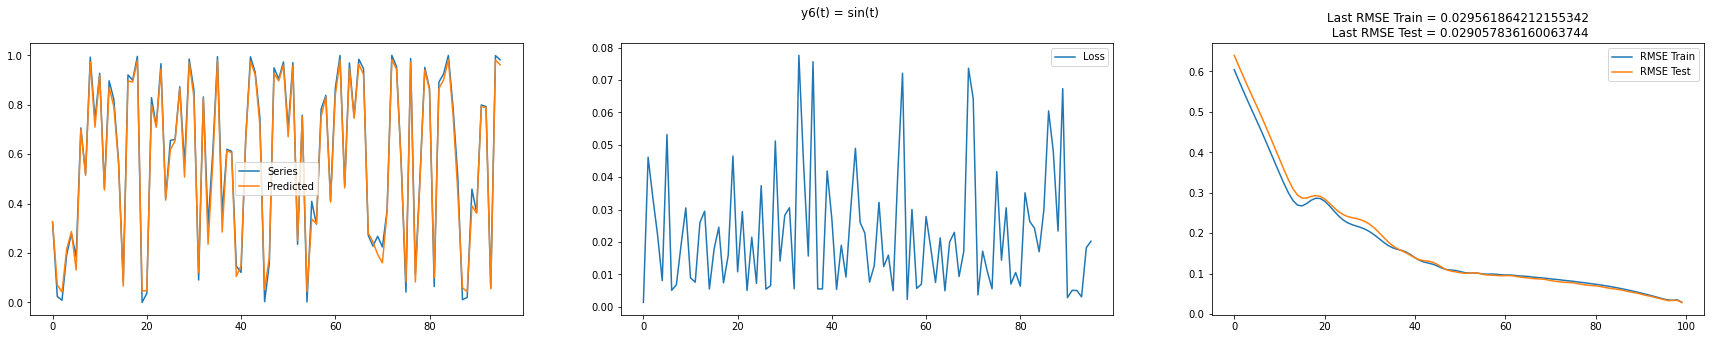

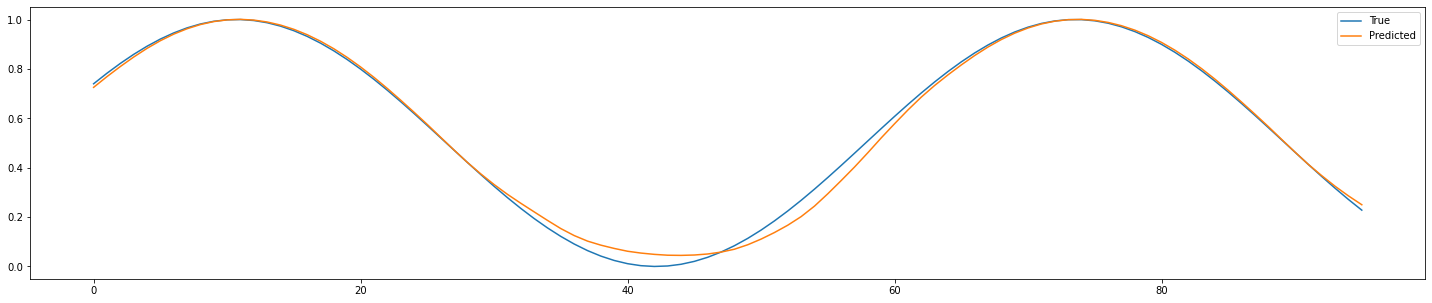

In [19]:
executeCNN_Lin("y6(t) = sin(t)", series6, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)